# PH7013
Sample code from https://qutip.org/docs/latest/guide/dynamics/dynamics-time.html

In [2]:
import numpy as np
from qutip import *
%matplotlib inline
import matplotlib.pyplot as plt
from qutip.qip.pulse import Pulse
from qutip.qip.device import Processor
from scipy.signal import argrelextrema

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import qutip_qip
from qutip import (Qobj, Options, basis, fock_dm, qeye, sigmax, sigmay,
                   sigmaz, tensor)
from qutip_qip.circuit import QubitCircuit
from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import Model, ModelProcessor
from qutip_qip.noise import Noise
from qutip_qip.operations import Gate
from scipy.optimize import curve_fit

In [3]:
with open("rename.py") as f:
    exec(f.read())

## Finding pulse duration

Parameters

In [4]:
VStd = 0.01
phaseStd = 0.382 / 180 * np.pi
detuningStd = 52769
samplingRate = 5898.24e6 # 5.89824 GS/s

omega = 20e6 # 20MHz
VNaught = 1
hbar = 1
phiNaught = 0
aNaught = 25 / 46

V = VNaught + np.random.normal(scale=VStd)
phi = phiNaught + np.random.normal(scale=phaseStd)
I = np.cos(phi)
Q = np.sin(phi)

Finding the pulse duration. When specifying Python functions for coefficients, the function must have (t,args) as the input variables, in that order.

In [5]:
psi0 = basis(2,0)

In [6]:
t_0 = 0
t_final = 100e-9
n_steps = int(samplingRate * (t_final - t_0))
t_find_pulse = np.linspace(t_0, t_final, n_steps)
def H_find_pulse(t, args):
    dwt = np.random.normal(scale=detuningStd) * t
    s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / t_final)
    # For 2 qubit
    # return omega * np.pi * V * s *((-I * np.cos(dwt) + Q * np.sin(dwt)) * tensor(identity(2),sigma_x()) + (I * np.sin(dwt) - Q * np.cos(dwt)) * tensor(identity(2),sigma_y()))
    return omega * np.pi * V * s *((-I * np.cos(dwt) + Q * np.sin(dwt)) * sigma_x() + (I * np.sin(dwt) - Q * np.cos(dwt)) * sigma_y())
# For 2 qubit
# result_find_pulse = sesolve(H_find_pulse, psi0, t_find_pulse, [tensor(sigmaz(),sigmaz())],options=Options(nsteps=10000))
result_find_pulse = sesolve(H_find_pulse, psi0, t_find_pulse, [sigmaz()],options=Options(nsteps=10000))

(<Figure size 800x400 with 1 Axes>,
 array([[<Axes: xlabel='time'>]], dtype=object))

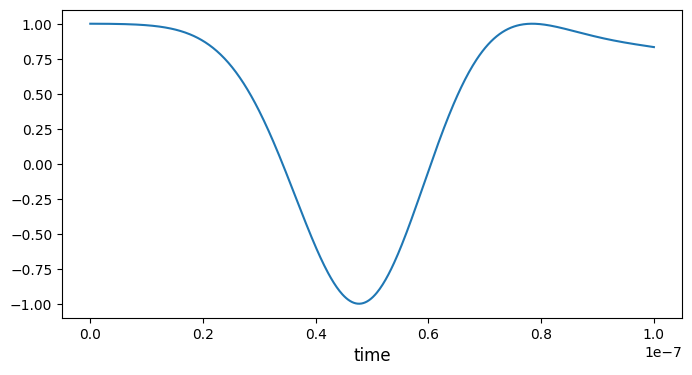

In [7]:
plot_expectation_values(result_find_pulse)

In [8]:
# maximum_array = argrelextrema(result_find_pulse.expect[0], np.greater)
minimum_array = argrelextrema(result_find_pulse.expect[0], np.less)
# first_max = maximum_array[0][0]
first_min = minimum_array[0][0]
pi_pulse_duration = result_find_pulse.times[first_min]
# pi_pulse_duration = np.absolute(result_find_pulse.times[first_min] - result_find_pulse.times[first_max])
pi_half_pulse_duration = pi_pulse_duration/2
print(pi_pulse_duration,pi_half_pulse_duration)

4.7619047619047613e-08 2.3809523809523807e-08


Solving the Hamiltonian

In [9]:
def H(t, args):
    dwt = np.random.normal(scale=detuningStd) * t
    s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / pi_pulse_duration)
    # return omega * np.pi * V * s * ((-I * np.cos(dwt) + Q * np.sin(dwt)) * tensor(identity(2),sigma_x()) + (I * np.sin(dwt) - Q * np.cos(dwt)) * tensor(identity(2),sigma_y()))
    return omega * np.pi * V * s * ((-I * np.cos(dwt) + Q * np.sin(dwt)) * sigma_x() + (I * np.sin(dwt) - Q * np.cos(dwt)) * sigma_y())

In [10]:
n_steps = int(samplingRate * (pi_pulse_duration - t_0))
t = np.linspace(t_0, pi_pulse_duration, n_steps)
# result = sesolve(H, psi0, t, [tensor(identity(2),sigmaz()),tensor(identity(2),sigmax()),tensor(identity(2),sigmay())],options=Options(nsteps=10000))
result = sesolve(H, psi0, t, [sigmaz(),sigmax(),sigmay()],options=Options(nsteps=10000))

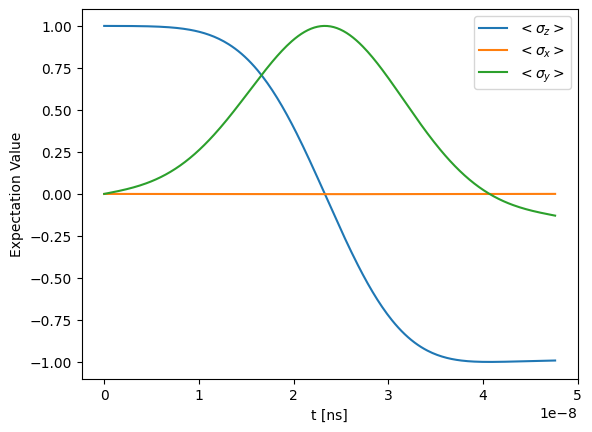

In [11]:
plt.plot(t, np.transpose(result.expect), label=[r"$<\sigma_z>$", r"$<\sigma_x>$", r"$<\sigma_y>$"])
plt.xlabel("t [ns]")
plt.ylabel("Expectation Value")
plt.legend()

## Randomize Benchmarking

In [29]:
import qutip_qip
from qutip import (Qobj, Options, basis, fock_dm, qeye, sigmax, sigmay,
                   sigmaz, tensor)
from qutip_qip.circuit import QubitCircuit
from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import Model, ModelProcessor
from qutip_qip.noise import Noise
from qutip_qip.operations import Gate
from scipy.optimize import curve_fit

In [30]:
x_rotation = lambda theta: np.matrix([
    [np.cos(theta / 2),        -1j * np.sin(theta/2)],
    [-1j * np.sin(theta / 2),  np.cos(theta / 2)]
])

y_rotation = lambda theta: np.matrix([
    [np.cos(theta / 2), -np.sin(theta / 2)],
    [np.sin(theta / 2), np.cos(theta / 2)]
])

In [27]:
rabi_frequency = 0.02
#pi_pulse_duration = 25

In [193]:
class MyModel(Model):
    """A custom Hamiltonian model with sigmax and sigmay control."""

    def get_control(self, label):
        """
        Get an available control Hamiltonian.
        For instance, sigmax control on the zeroth
        qubits is labeled "sx0".

        Args:
            label (str): The label of the Hamiltonian

        Returns:
            The Hamiltonian and target qubits as a tuple
            (qutip.Qobj, list).
        """
        return self.controls[label]

In [50]:
class MyCompiler(GateCompiler):
    """
    Custom compiler for generating pulses from gates using
    the base class GateCompiler.

    Args:
        num_qubits (int): The number of qubits in the processor
        params (dict): A dictionary of parameters for gate pulses
                       such as the pulse amplitude.
    """

    def __init__(self, num_qubits, params):
        super().__init__(num_qubits, params=params)
        self.params = params
        self.gate_compiler = {
            "ROT": self.rotation_with_phase_compiler,
            "RX": self.single_qubit_gate_compiler,
            "RY": self.single_qubit_gate_compiler,
        }

    def generate_pulse(self, gate, tlist, coeff, phase=0.0):
        """Generates the pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.
            tlist (array): A list of times for the evolution.
            coeff (array): An array of coefficients for the gate pulses
            phase (float): The value of the phase for the gate.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        pulse_info = [
            # (control label, coeff)
            ("sx" + str(gate.targets[0]), np.cos(phase) * coeff),
            ("sy" + str(gate.targets[0]), np.sin(phase) * coeff),
        ]
        return [Instruction(gate, tlist=tlist, pulse_info=pulse_info)]

    def single_qubit_gate_compiler(self, gate, args):
        """Compiles single-qubit gates to pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        # gate.arg_value is the rotation angle
        tlist = np.abs(gate.arg_value) / self.params["pulse_amplitude"]
        coeff = self.params["pulse_amplitude"] * np.sign(gate.arg_value)
        if gate.name == "RX":
            return self.generate_pulse(gate, tlist, coeff, phase=0.0)
        elif gate.name == "RY":
            return self.generate_pulse(gate, tlist, coeff, phase=np.pi / 2)

    def rotation_with_phase_compiler(self, gate, args):
        """Compiles gates with a phase term.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        # gate.arg_value is the pulse phase
        tlist = self.params["duration"]
        coeff = self.params["pulse_amplitude"]
        return self.generate_pulse(gate, tlist, coeff, phase=gate.arg_value)

In [194]:
class KayCompiler(GateCompiler):
    """
    Custom compiler for generating pulses from gates using
    the base class GateCompiler.

    Args:
        num_qubits (int): The number of qubits in the processor
        params (dict): A dictionary of parameters for gate pulses
                       such as the pulse amplitude.
    """

    def __init__(self, num_qubits, params):
        super().__init__(num_qubits, params=params)
        self.params = params
        self.gate_compiler = {"XPulse":     self.kay_compiler,
                        "YPulse":           self.kay_compiler,
                        "XHalfPulse":       self.kay_compiler,
                        "YHalfPulse":       self.kay_compiler,
                        "XHalfMinusPulse":  self.kay_compiler,
                        "YHalfMinusPulse":  self.kay_compiler}


    def generate_pulse(self, gate, tlist, coeff, phase=0.0):
        """Generates the pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.
            tlist (array): A list of times for the evolution.
            coeff (array): An array of coefficients for the gate pulses
            phase (float): The value of the phase for the gate.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        return [Instruction(gate, tlist=tlist)]

    def kay_compiler(self, gate, args):
        """Compiles gates with a phase term.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        # gate.arg_value is the pulse phase
        tlist = self.params["duration"]
        coeff = self.params["pulse_amplitude"]
        return self.generate_pulse(gate, tlist, coeff)

In [195]:
# Define a circuit and run the simulation
num_qubits = 1

circuit = QubitCircuit(1)
circuit.add_gate("XPulse", targets=0)

myprocessor = ModelProcessor(model=MyModel(num_qubits))
# myprocessor.native_gates = ["RX", "RY"]

mycompiler = KayCompiler(num_qubits, {"pulse_amplitude": rabi_frequency,"duration" : t})

myprocessor.load_circuit(circuit, compiler=mycompiler)
result = myprocessor.run_state(basis(2, 0))

fig, ax = myprocessor.plot_pulses(figsize=(5, 3), dpi=120,
                                  use_control_latex=False)
ax[-1].set_xlabel("$t$")
fig.tight_layout()

ValueError: zero-size array to reduction operation maximum which has no identity

In [179]:
class ClassicalCrossTalk(Noise):
    def __init__(self, ratio):
        self.ratio = ratio

    def get_noisy_dynamics(self, dims=None, pulses=None,
                           systematic_noise=None):
        """Adds noise to the control pulses.

        Args:
            dims: Dimension of the system, e.g., [2,2,2,...] for qubits.
            pulses: A list of Pulse objects, representing the compiled pulses.
            systematic_noise: A Pulse object with no ideal control,
            used to represent pulse-independent noise such as decoherence
            (not used in this example).
        Returns:
            pulses: The list of modified pulses according to the noise model.
            systematic_noise: A Pulse object (not used in this example).
        """
        for i, pulse in enumerate(pulses):
            if "sx" not in pulse.label and "sy" not in pulse.label:
                continue  # filter out other pulses, e.g. drift
            target = pulse.targets[0]
            if target != 0:  # add pulse to the left neighbour
                pulses[i].add_control_noise(
                    self.ratio * pulse.qobj,
                    targets=[target - 1],
                    coeff=pulse.coeff,
                    tlist=pulse.tlist,
                )
            if target != len(dims) - 1:  # add pulse to the right neighbour
                pulses[i].add_control_noise(
                    self.ratio * pulse.qobj,
                    targets=[target + 1],
                    coeff=pulse.coeff,
                    tlist=pulse.tlist,
                )
        return pulses, systematic_noise

In [184]:
def single_crosstalk_simulation(num_gates):
    """
    A single simulation, with num_gates representing the number of rotations.

    Args:
        num_gates (int): The number of random gates to add in the simulation.

    Returns:
        result (qutip.solver.Result):
            A qutip Result object obtained from any of the
            solver methods such as mesolve.
    """
    # Qubit-0 is the target qubit. Qubit-1 suffers from crosstalk.
    num_qubits = 2
    myprocessor = ModelProcessor(model=MyModel(num_qubits))
    # Add qubit frequency detuning 1.852MHz for the second qubit.
    # myprocessor.add_drift(2 * np.pi * (sigmaz() + 1) / 2 * 1.852, targets=1)
    myprocessor.native_gates = None  # Remove the native gates
    myprocessor.user_gates ={   "XPulse":           original_Hamiltonian(pi_pulse_duration,0),
                                "YPulse":           original_Hamiltonian(pi_pulse_duration,np.pi / 2),
                                "XHalfPulse":       original_Hamiltonian(pi_half_pulse_duration,0),
                                "YHalfPulse":       original_Hamiltonian(pi_half_pulse_duration,np.pi / 2),
                                "XHalfMinusPulse":  original_Hamiltonian(pi_half_pulse_duration,-np.pi),
                                "YHalfMinusPulse":  original_Hamiltonian(pi_half_pulse_duration,-np.pi / 2)}    
    mycompiler = MyCompiler(num_qubits,{"pulse_amplitude": rabi_frequency, "duration": pi_pulse_duration})
    # myprocessor.add_noise(ClassicalCrossTalk(1.0))
    # Define a randome circuit.
    gates_set = [
        Gate("XPulse", 0),
        Gate("YPulse", 0),
        Gate("XHalfPulse", 0),
        Gate("YHalfPulse", 0),
        Gate("XHalfMinusPulse", 0),
        Gate("YHalfMinusPulse", 0)
    ]
    circuit = QubitCircuit(num_qubits)
    for ind in np.random.randint(0, 6, num_gates):
        circuit.add_gate(gates_set[ind], targets=[0])
    # Simulate the circuit.
    myprocessor.load_circuit(circuit, compiler=mycompiler)
    init_state = tensor(
        [Qobj([[init_fid, 0], [0, 0.025]]),
         Qobj([[init_fid, 0], [0, 0.025]])]
    )
    # increase the maximal allowed steps
    options = Options(nsteps=10000)
    e_ops = [tensor([qeye(2), fock_dm(2)])]  # observable

    # compute results of the run using a solver of choice
    result = myprocessor.run_state(
        init_state, solver="mesolve", options=options, e_ops=e_ops
    )
    # measured expectation value at the end
    result = result.expect[0][-1]
    return result

In [185]:
# The full simulation may take several hours
num_sample = 10
fidelity = []
fidelity_error = []
init_fid = 0.975
num_gates_list = [25, 50, 75, 100, 125, 150]

# The full simulation is defined in the commented lines below.
# from joblib import Parallel, delayed  # for parallel simulations
# num_sample = 1600
# num_gates_list = [250, 500, 750, 1000, 1250, 1500]

for num_gates in num_gates_list:
    expect = [single_crosstalk_simulation(num_gates) for i in range(num_sample)]
    fidelity.append(np.mean(expect))
    fidelity_error.append(np.std(expect) / np.sqrt(num_sample))

ValueError: Unsupported gate XHalfMinusPulse

In [151]:
# Recorded result of a full simulation

def rb_curve(x, a):
    return (1 / 2 + np.exp(-2 * a * x) / 2) * 0.975


pos, cov = curve_fit(rb_curve, num_gates_list, fidelity, p0=[0.001])

xline = np.linspace(0, num_gates_list[-1], pi_pulse_duration)
yline = rb_curve(xline, *pos)

fig, ax = plt.subplots(figsize=(5, 3), dpi=100)
ax.errorbar(
    num_gates_list, fidelity, yerr=fidelity_error, fmt=".",
    capsize=2, color="slategrey"
)
ax.plot(xline, yline, color="slategrey")
ax.set_ylabel("Average fidelity")
ax.set_xlabel(r"Number of $\pi$ rotations")
ax.set_xlim((0, num_gates_list[-1]));

ValueError: `ydata` must not be empty!

In [26]:
VStd = 0.01
phaseStd = 0.382 / 180 * np.pi
detuningStd = 52769
samplingRate = 5898.24e6 # 5.89824 GS/s

omega = 20e6 # 20MHz
VNaught = 1
hbar = 1
phiNaught = 0
aNaught = 25 / 46

V = VNaught + np.random.normal(scale=VStd)
psi0 = basis(2,0)

t_0 = 0
t_final = pi_pulse_duration

In [167]:
num_qubits = 1
myprocessor = ModelProcessor(model=MyModel(num_qubits))
#myprocessor = Processor(N=1)
# Add qubit frequency detuning 1.852MHz for the second qubit.
# myprocessor.add_drift(2 * np.pi * (sigmaz() + 1) / 2 * 1.852, targets=1)
myprocessor.native_gates = None  # Remove the native gates
mycompiler = MyCompiler(num_qubits,{"pulse_amplitude": rabi_frequency, "duration": pi_pulse_duration})
# myprocessor.add_noise(ClassicalCrossTalk(1.0))
# Define a randome circuit.

circuit = QubitCircuit(num_qubits)
circuit.user_gates ={   "XPulse":           original_Hamiltonian(pi_pulse_duration,0),
                        "YPulse":           original_Hamiltonian(pi_pulse_duration,np.pi / 2),
                        "XHalfPulse":       original_Hamiltonian(pi_half_pulse_duration,0),
                        "YHalfPulse":       original_Hamiltonian(pi_half_pulse_duration,np.pi / 2),
                        "XHalfMinusPulse":  original_Hamiltonian(pi_half_pulse_duration,-np.pi),
                        "YHalfMinusPulse":  original_Hamiltonian(pi_half_pulse_duration,-np.pi / 2)}   
gates_set = [
    Gate("XPulse", 0),
    Gate("YPulse", 0),
    Gate("XHalfPulse", 0),
    Gate("YHalfPulse", 0),
    Gate("XHalfMinusPulse", 0),
    Gate("YHalfMinusPulse", 0)
] 
for ind in np.random.randint(0, 6, num_gates):
    circuit.add_gate(gates_set[ind], targets=[0])
# Simulate the circuit.
myprocessor.load_circuit(circuit, compiler=mycompiler)
# myprocessor.load_circuit(circuit)
init_state = tensor(
    [Qobj([[init_fid, 0], [0, 0.025]]),
        Qobj([[init_fid, 0], [0, 0.025]])]
)
# increase the maximal allowed steps
options = Options(nsteps=10000)
e_ops = [sigmaz()]  # observable

# compute results of the run using a solver of choice
result = myprocessor.run_state(
    init_state, solver="mesolve", options=options, e_ops=e_ops
)
# measured expectation value at the end
result = result.expect[0][-1]

ValueError: Unsupported gate XHalfPulse

## Customize device

In [18]:
def original_Hamiltonian(t, phiNaught, N=None, target=0):
    """Single-qubit evolution.

    Returns
    -------
    result : qobj
        Quantum object for operator describing the rotation.

    """
    phi = phiNaught + np.random.normal(scale=phaseStd)
    I = np.cos(phi)
    Q = np.sin(phi)

    dwt = np.random.normal(scale=detuningStd) * t
    s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / t_final)
    H = omega * np.pi * V * s *((-I * np.cos(dwt) + Q * np.sin(dwt)) * sigma_x() + (I * np.sin(dwt) - Q * np.cos(dwt)) * sigma_y())
    return Qobj(H/(1j* hbar), dims=[[2], [2]])

In [19]:
class MyModel(Model):
    def __init__(
        self, num_qubits, dims=None):
        super().__init__(num_qubits, dims=dims)
        # Control Hamiltonians
        self.controls = {}
        self.controls.update(
            {"sx0": (2 * np.pi * sigmax(),0)}
        )
        self.controls.update(
            {"sy0": (2 * np.pi * sigmay(),0)}
        ),

    def get_control(self, label):
        """
        The mandatory method. It Returns a pair of Qobj and int representing
        the control Hamiltonian and the target qubit.
        """
        return self.controls[label]

    def get_control_labels(self):
        """
        It returns all the labels of availble controls.
        """
        return self.controls.keys()

In [35]:
class MyCompiler(GateCompiler):
    """
    Custom compiler for generating pulses from gates using
    the base class GateCompiler.

    Args:
        num_qubits (int): The number of qubits in the processor
        params (dict): A dictionary of parameters for gate pulses
                       such as the pulse amplitude.
    """

    def __init__(self, num_qubits, params):
        super().__init__(num_qubits, params=params)
        self.params = params
        self.gate_compiler = {
            "ROT": self.rotation_with_phase_compiler,
            "RX": self.single_qubit_gate_compiler,
            "RY": self.single_qubit_gate_compiler,
            "XPulse": self.super_conducting_compiler,
            "YPulse":self.super_conducting_compiler,
            "XHalfPulse":self.super_conducting_compiler,
            "YHalfPulse":self.super_conducting_compiler,
            "XHalfMinusPulse":self.super_conducting_compiler,
            "YHalfMinusPulse":self.super_conducting_compiler
        }

    def generate_pulse(self, gate, tlist, coeff, phase=0.0):
        """Generates the pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.
            tlist (array): A list of times for the evolution.
            coeff (array): An array of coefficients for the gate pulses
            phase (float): The value of the phase for the gate.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        pulse_info = [
            # (control label, coeff)
            ("sx" + str(gate.targets[0]), np.cos(phase) * coeff),
            ("sy" + str(gate.targets[0]), np.sin(phase) * coeff),
        ]
        return [Instruction(gate, tlist=tlist, pulse_info=pulse_info)]

    def single_qubit_gate_compiler(self, gate, args):
        """Compiles single-qubit gates to pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        # gate.arg_value is the rotation angle
        tlist = np.abs(gate.arg_value) / self.params["pulse_amplitude"]
        coeff = self.params["pulse_amplitude"] * np.sign(gate.arg_value)
        if gate.name == "RX":
            return self.generate_pulse(gate, tlist, coeff, phase=0.0)
        elif gate.name == "RY":
            return self.generate_pulse(gate, tlist, coeff, phase=np.pi / 2)

    def rotation_with_phase_compiler(self, gate, args):
        """Compiles gates with a phase term.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        # gate.arg_value is the pulse phase
        tlist = self.params["duration"]
        coeff = self.params["pulse_amplitude"]
        return self.generate_pulse(gate, tlist, coeff, phase=gate.arg_value)
    
    def super_conducting_compiler(self,gate,args):
        tlist = self.params["duration"]
        coeff = self.params["pulse_amplitude"]
        return self.generate_pulse(gate, tlist, coeff, phase=0)

In [38]:
# Define a circuit and run the simulation
num_qubits = 1

circuit = QubitCircuit(num_qubits)
circuit.user_gates ={   "XPulse":           original_Hamiltonian(pi_pulse_duration,0),
                        "YPulse":           original_Hamiltonian(pi_pulse_duration,np.pi / 2),
                        "XHalfPulse":       original_Hamiltonian(pi_half_pulse_duration,0),
                        "YHalfPulse":       original_Hamiltonian(pi_half_pulse_duration,np.pi / 2),
                        "XHalfMinusPulse":  original_Hamiltonian(pi_half_pulse_duration,-np.pi),
                        "YHalfMinusPulse":  original_Hamiltonian(pi_half_pulse_duration,-np.pi / 2)}   
circuit.add_gate("RX", targets=0, arg_value=np.pi / 2)
circuit.add_gate("XPulse", targets=0)

myprocessor = ModelProcessor(model=MyModel(num_qubits))
myprocessor.native_gates = ["RX", "RY"]

mycompiler = MyCompiler(num_qubits, {"pulse_amplitude": 0.02})

myprocessor.load_circuit(circuit, compiler=mycompiler)
result = myprocessor.run_state(basis(2, 0))

fig, ax = myprocessor.plot_pulses(figsize=(5, 3), dpi=120,
                                  use_control_latex=False)
ax[-1].set_xlabel("$t$")
fig.tight_layout()

KeyError: '_gate_XPulse'

In [30]:
def single_crosstalk_simulation(num_gates):
    """
    A single simulation, with num_gates representing the number of rotations.

    Args:
        num_gates (int): The number of random gates to add in the simulation.

    Returns:
        result (qutip.solver.Result):
            A qutip Result object obtained from any of the
            solver methods such as mesolve.
    """
    # Qubit-0 is the target qubit. Qubit-1 suffers from crosstalk.
    num_qubits = 2
    myprocessor = ModelProcessor(model=MyModel(num_qubits))
    # Add qubit frequency detuning 1.852MHz for the second qubit.
    myprocessor.add_drift(2 * np.pi * (sigmaz() + 1) / 2 * 1.852, targets=1)
    myprocessor.native_gates = None  # Remove the native gates
    mycompiler = MyCompiler(num_qubits,
                            {"pulse_amplitude": 0.02, "duration": 25})
    myprocessor.add_noise(ClassicalCrossTalk(1.0))
    # Define a randome circuit.
    gates_set = [
        Gate("ROT", 0, arg_value=0),
        Gate("ROT", 0, arg_value=np.pi / 2),
        Gate("ROT", 0, arg_value=np.pi),
        Gate("ROT", 0, arg_value=np.pi / 2 * 3),
    ]
    circuit = QubitCircuit(num_qubits)
    for ind in np.random.randint(0, 4, num_gates):
        circuit.add_gate(gates_set[ind])
    # Simulate the circuit.
    myprocessor.load_circuit(circuit, compiler=mycompiler)
    init_state = tensor(
        [Qobj([[init_fid, 0], [0, 0.025]]),
         Qobj([[init_fid, 0], [0, 0.025]])]
    )
    # increase the maximal allowed steps
    options = Options(nsteps=10000)
    e_ops = [tensor([qeye(2), fock_dm(2)])]  # observable

    # compute results of the run using a solver of choice
    result = myprocessor.run_state(
        init_state, solver="mesolve", options=options, e_ops=e_ops
    )
    # measured expectation value at the end
    result = result.expect[0][-1]
    return result


# The full simulation may take several hours
# so we just choose num_sample=2 and num_gates=250 as a test
num_sample = 2
fidelity = []
fidelity_error = []
init_fid = 0.975
num_gates_list = [250]

# The full simulation is defined in the commented lines below.

# from joblib import Parallel, delayed  # for parallel simulations
# num_sample = 1600
# num_gates_list = [250, 500, 750, 1000, 1250, 1500]

for num_gates in num_gates_list:
    expect = [single_crosstalk_simulation(num_gates)
              for i in range(num_sample)]
    fidelity.append(np.mean(expect))
    fidelity_error.append(np.std(expect) / np.sqrt(num_sample))

TypeError: 'int' object is not subscriptable

In [25]:
myprocessor = ModelProcessor(model=MyModel(num_qubits))
myprocessor.native_gates = ["RX", "RY"]

mycompiler = MyCompiler(num_qubits, {"pulse_amplitude": 0.02})

myprocessor.load_circuit(circuit, compiler=mycompiler)
result = myprocessor.run_state(basis(2, 0))